<a href="https://colab.research.google.com/github/neermesh/deep-learning/blob/master/tensorflow_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
import time
import math
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
    
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing as prep

Using TensorFlow backend.


In [0]:
from pandas_datareader import data as pdr
df = pdr.get_data_yahoo('CIPLA.NS')  


In [4]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,339.500000,336.000000,338.000000,337.549988,635013.0,319.540070
2010-01-05,342.399994,330.500000,338.549988,331.500000,1664976.0,313.812958
2010-01-06,348.899994,330.350006,332.000000,344.899994,3580916.0,326.497986
2010-01-07,350.399994,340.500000,346.000000,342.049988,1555841.0,323.800049
2010-01-08,346.500000,340.200012,345.000000,341.100006,913410.0,322.900757
...,...,...,...,...,...,...
2020-01-23,475.850006,459.350006,464.500000,465.149994,5783699.0,465.149994
2020-01-27,466.500000,454.200012,457.500000,464.450012,5849003.0,464.450012
2020-01-28,468.000000,458.950012,465.000000,464.700012,3592413.0,464.700012


In [0]:
df = df[[ "High", "Low", "Open","Close"]]

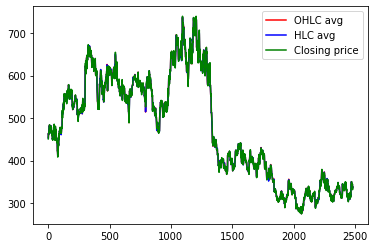





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/5





 - 25s - loss: 0.0054
Epoch 2/5
 - 15s - loss: 4.4267e-04
Epoch 3/5
 - 16s - loss: 4.0620e-04
Epoch 4/5
 - 16s - loss: 3.8611e-04
Epoch 5/5
 - 16s - loss: 3.6642e-04
Train RMSE: 8.61
Test RMSE: 21.10


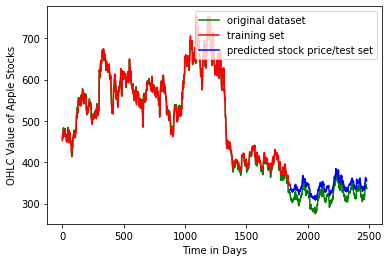

Last Day Value: 354.7384338378906
Next Day Value: 367.1948547363281


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


In [11]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM


def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)
 

# FOR REPRODUCIBILITY
np.random.seed(7)

dataset = df

# IMPORTING DATASET 
#dataset = pd.read_csv('apple_share_price.csv', usecols=[1,2,3,4])
dataset = dataset.reindex(index = dataset.index[::-1])
#print(dataset)


# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

# PLOTTING ALL INDICATORS IN ONE PLOT
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()

# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adagrad') # Try SGD, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()

# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)


In [0]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

In [0]:
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [0]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [9]:


window = 20
X_train, y_train, X_test, y_test = preprocess_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)



X_train (2215, 20, 6)
y_train (2215,)
X_test (246, 20, 6)
y_test (246,)


In [10]:
model = build_model([X_train.shape[2], window, 100, 1])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 6), units=20)`
  



Compilation Time :  0.02608513832092285


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


In [11]:
model.fit(
    X_train,
    y_train,
    batch_size=768,
    epochs=5,
    validation_split=0.1,
    verbose=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










In [12]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.04 MSE (0.20 RMSE)
Test Score: 0.01 MSE (0.08 RMSE)


In [0]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

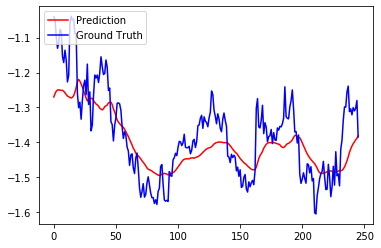

In [14]:
plt.plot(pred, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()

In [0]:
from sklearn.model_selection import train_test_split
test, train = train_test_split(df, train_size=0.2)

In [0]:
train = train['Adj Close']
test = test['Adj Close']

In [0]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train.values.reshape(-1, 1))
#test_scaled = sc.fit_transform(test.values.reshape(-1, 1))

In [43]:
train_scaled

array([[0.21252601],
       [0.54455866],
       [0.01770604],
       ...,
       [0.23361188],
       [0.46473312],
       [0.06146975]])

In [44]:
train_scaled.shape

(1986, 1)

In [0]:
X_train = []
y_train = []
for i in range(60,1984):
    X_train.append(train_scaled[i-60:i,0])
    y_train.append(train_scaled[i,0])
X_train,y_train = np.array(X_train), np.array(y_train)

In [46]:
X_train.shape

(1924, 60)

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [48]:
X_train.shape

(1924, 60, 1)

In [0]:
from tensorflow.keras import layers

In [0]:


regressor = tf.keras.Sequential()
#regressor.add(layers.Bidirectional(layers.CuDNNLSTM(256, return_sequences=True), 
#                               input_shape=(X_train.shape[1],1)))

regressor.add(layers.LSTM(32, input_shape=(X_train.shape[1],1), return_sequences=True))
regressor.add(layers.Dropout(0.2))




regressor.add(layers.LSTM(4, return_sequences=True))
regressor.add(layers.Dropout(0.2))

regressor.add(layers.Flatten())

regressor.add(layers.Dense(1))
regressor.compile(optimizer='adam',loss='mean_squared_error')

In [51]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 32)            4352      
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 4)             592       
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 4)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 240)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 241       
Total params: 5,185
Trainable params: 5,185
Non-trainable params: 0
____________________________________________________

In [52]:
regressor.fit(X_train,y_train,epochs=30,batch_size=32,validation_split=0.2)

Train on 1539 samples, validate on 385 samples
Epoch 1/30
1539/1539 [==============================] - 6s 4ms/sample - loss: 0.1260 - val_loss: 0.0769
Epoch 2/30
1539/1539 [==============================] - 4s 3ms/sample - loss: 0.0829 - val_loss: 0.0754
Epoch 3/30
1539/1539 [==============================] - 4s 3ms/sample - loss: 0.0782 - val_loss: 0.0750
Epoch 4/30
1539/1539 [==============================] - 4s 3ms/sample - loss: 0.0800 - val_loss: 0.0750
Epoch 5/30
1539/1539 [==============================] - 4s 3ms/sample - loss: 0.0782 - val_loss: 0.0757
Epoch 6/30
1539/1539 [==============================] - 4s 3ms/sample - loss: 0.0785 - val_loss: 0.0758
Epoch 7/30
1539/1539 [==============================] - 4s 3ms/sample - loss: 0.0776 - val_loss: 0.0756
Epoch 8/30
1539/1539 [==============================] - 4s 3ms/sample - loss: 0.0785 - val_loss: 0.0765
Epoch 9/30
1539/1539 [==============================] - 4s 3ms/sample - loss: 0.0775 - val_loss: 0.0764
Epoch 10/30
1539/

In [0]:
#Here

(497,)

In [53]:
train

Date
2014-02-14    364.139160
2019-07-30    517.000000
2011-08-18    274.448151
2019-11-13    447.899994
2019-03-12    535.641785
                 ...    
2015-09-10    642.276733
2019-02-06    531.863770
2013-03-14    373.846649
2020-01-16    480.250000
2010-05-18    294.596039
Name: Adj Close, Length: 1986, dtype: float64

In [0]:
dataset_total = pd.concat((train,test),axis=0)
inputs = dataset_total[len(df)- len(test)-60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60,497):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [55]:
df[len(df)- len(test)-60:]

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-10-25,604.000000,589.500000,599.000000,592.650024,991374.0,586.384583
2017-10-26,616.799988,592.549988,595.400024,611.500000,2002276.0,605.035278
2017-10-27,629.799988,616.200012,625.000000,625.049988,2198491.0,618.442017
2017-10-30,630.000000,614.549988,623.250000,626.049988,1045267.0,619.431396
2017-10-31,634.900024,621.599976,629.000000,627.599976,1522851.0,620.965088
...,...,...,...,...,...,...
2020-01-23,475.850006,459.350006,464.500000,465.149994,5783699.0,465.149994
2020-01-27,466.500000,454.200012,457.500000,464.450012,5849003.0,464.450012
2020-01-28,468.000000,458.950012,465.000000,464.700012,3592413.0,464.700012


In [25]:
test

Date
2014-07-23    431.095520
2011-03-21    275.758331
2011-03-07    292.576935
2013-02-27    353.371246
2010-06-23    321.007446
                 ...    
2015-07-31    694.711365
2015-10-27    672.734924
2012-11-26    370.304749
2018-08-02    631.749817
2010-11-09    335.366180
Name: Adj Close, Length: 497, dtype: float64

In [0]:
pd.DataFrame(predicted_stock_price,index=test.index)

ValueError: ignored

In [56]:
pd.concat((pd.DataFrame(test),pd.DataFrame(predicted_stock_price)),axis=1)

,Adj Close,0
1970-01-01 00:00:00.000000000,NaN,NaN
1970-01-01 00:00:00.000000001,NaN,NaN
1970-01-01 00:00:00.000000002,NaN,NaN
1970-01-01 00:00:00.000000003,NaN,NaN
1970-01-01 00:00:00.000000004,NaN,NaN
...,...,...
2019-12-10 00:00:00.000000000,453.049988,NaN
2019-12-23 00:00:00.000000000,467.850006,NaN
2020-01-01 00:00:00.000000000,475.899994,NaN
2020-01-15 00:00:00.000000000,484.000000,NaN


ConversionError: ignored

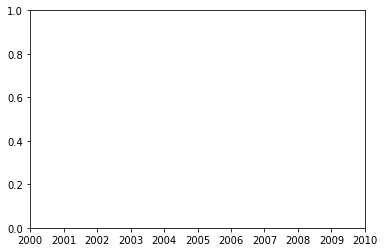

In [0]:


# Visualising the results
plt.plot(test, color = 'red', label = 'Real TATA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TATA Stock Price')
plt.title('TATA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TATA Stock Price')
plt.legend()
plt.show()

In [0]:
X_test.shape

(437, 60, 1)

In [0]:
pd.DataFrame({'real':df_test.tolist(),'predicted':predicted_stock_price.tolist()})

ValueError: ignored